In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('stocks2019.csv')
df2= pd.read_csv('stocks2020.csv')

display(df1.head())

,X,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
1,2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2,2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
3,2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
4,2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [3]:
# Get return
colnames = df1.columns.values[1:]
for i in colnames:
    df1[i] = df1[i].pct_change()
    df2[i] = df2[i].pct_change()

df1 = df1.drop([0])  
df2 = df2.drop([0])

df1 = df1.set_index('X')
df2 = df2.set_index('Unnamed: 0')

print('The daily returns are:')
display(df1.head())

stocks2019 = df1.iloc[:,1:]
index2019 = df1.iloc[:,0]
stocks2020 = df2.iloc[:,1:]
index2020 = df2.iloc[:,0]

#Obtain correlation matrix for df1
cor_stocks2019 = stocks2019.corr().to_numpy()
#print('\n\nThe correlation between stocks returns are:')
#display(cor_stocks2019.head())

The daily returns are:


,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [4]:
num_stocks = len(cor_stocks2019)
len_constr = num_stocks**2 + num_stocks + 1 #constrains length
def create_optimize(m=5):
    # Maximize the similarity 
    # Objectives
    obj = np.concatenate((np.squeeze(cor_stocks2019.reshape(1,-1)), \
                     np.zeros(100)))
  # Create frame for matrices A, sense and b
    sense = np.array(['<']*len_constr)
    b = np.zeros(len_constr)
    A = np.zeros((len_constr, len(obj)))
    
    # x_ij <= yj
    row = 0
    for i in range(num_stocks): #over each stock in index
        for j in range(num_stocks): #over column
            A[row, row] = 1
            A[row, num_stocks**2 + j] = -1
            sense[row] = '<'
            row += 1
            
    # sum(x_ij) = 1
    for j in range(num_stocks):
        start_col = j * 100
        A[row, start_col:(start_col + 100)] = 1
        b[row] = 1
        sense[row] = '='
        row += 1
    
    #sum(y_j) = m
    A[row, num_stocks**2:] = 1
    b[row] = m
    sense[row] = '='
    
    #return obj, A, sense, b
    
    # Optimization
    biMod = gp.Model()
    biMod_x = biMod.addMVar(len(obj),vtype=['B']*len(obj)) # vtype can be: 'C' or 'I' or 'B'
    biMod_con = biMod.addMConstrs(A, biMod_x, sense, b)
    biMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    biMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    biMod.optimize()
    
    return biMod.x, biMod.objVal
    


In [5]:
def get_weight(x, df=df1, m=5):
    
    def get_stock(x):
        stock_loc =[-1] #so that it returns location for index fund at the end
        y = x[-100:]
        [stock_loc.append(i) for i in range(len(y)) if np.isclose(y[i],1)]
        return (np.array(stock_loc) + 1).tolist() #shift right by 1 unit to account for the added index func column
        
    #stock returns that have been chosen
    df = eval('df.iloc[:,get_stock(x)]')
    index = df.iloc[:,0].to_numpy()
    stocks = df.iloc[:,1:].to_numpy()
    
    # Number of rows/days in returns df
    nrow = len(index)
    # Length of constraint
    len_constr = nrow*2 + 1
    
    obj = np.concatenate((np.ones(nrow),np.zeros(m)))
    A = np.zeros((len_constr, nrow + m))
    sense = np.array(['>']*(len_constr - 1) + ['='])
    b = np.concatenate((index,\
                        -index, np.array([1])))
    
    for day in range(nrow):
        #for rows with positive index returns
        A[day, day] = 1 # the "y"s
        A[day, nrow:] = stocks[day, :]
        
        #for rows with negative index returns
        A[nrow + day, day] = 1 # the "y"s
        A[nrow + day, nrow:] = -stocks[day, :]
    
    # All weights sum to 1
    A[-1, nrow:] = 1 
    
    # Optimization
    biMod = gp.Model()
    biMod_x = biMod.addMVar(len(obj),vtype=['C']*len(obj)) 
    biMod_con = biMod.addMConstrs(A, biMod_x, sense, b)
    biMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    biMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    biMod.optimize()
    
    return biMod.x[-m:], get_stock(x)

# Get performance of the index fund created
def performance(stock_loc, w, df=df2):
    stocks = df.iloc[:,stock_loc[1:]].to_numpy()
    index = df.iloc[:,0].to_numpy()
    
    return abs(index - stocks.dot(w)).sum()

def plot_performance(out_samp, in_samp, M):
    plt.figure(figsize=(10,8))
    plt.plot(M ,out_samp, label='Out-of-sample')
    plt.plot(M ,in_samp, label='In-sample')
    plt.legend()
    plt.show()

In [6]:
def optimize_weight(m=5, df=df1):
    
    def get_stock(x):
        stock_loc =[-1] #so that it returns location for index fund at the end
        y = x[-100:]
        [stock_loc.append(i) for i in range(len(y)) if np.isclose(y[i],1)]
        return (np.array(stock_loc) + 1).tolist() #shift right by 1 unit to account for the added index func
    
    index = df.iloc[:,0].to_numpy() #index return
    stocks = df.iloc[:,1:].to_numpy() #lists of stock returns 
    
    # Number of stocks in the index
    n = stocks.shape[1]
    # Number of rows/days in returns df
    nrow = len(index)
    # Length of constraint
    len_constr = nrow*2 + n + 2
    
    # abs value to minimize; yi; wi
    obj = np.concatenate((np.ones(nrow),np.zeros(n*2)))
    A = np.zeros((len_constr, nrow + n*2))
    sense = np.array(['>']*(nrow*2) + ['<']*(n) + ['=']*2)
    b = np.concatenate((index,\
                        -index, np.array([0]*n),np.array([1,m])))
    
    for day in range(nrow):
        #for rows with positive index returns
        A[day, day] = 1
        A[day, nrow:nrow+n] = stocks[day, :]
        
        #for rows with negative index returns
        A[nrow + day, day] = 1 
        A[nrow + day, nrow:nrow+n] = -stocks[day, :]
        
    # Go over each stock such that wi > 0 only if yi >0
    # In other words, we want to have wi-yi  <= 0
    # the 'M' in the big M method equals 1 here since weights are fractions and will be less than 1
    for i in range(n):
        A[nrow*2 + i, nrow + i] = 1 # the "w"s
        A[nrow*2 + i, nrow + n + i] = -1 # the "y"s
    
    # All weights sum to 1
    A[-2, (nrow):(nrow+n)] = 1 
    
    # All y_i sum to m -> the stocks to be picekd 
    A[-1, (nrow+n):(nrow+n*2)] = 1
    
    # Optimization
    biMod = gp.Model()
    biMod_x = biMod.addMVar(len(obj),vtype=['C']*(nrow + n) + ['B']*n) 
    biMod_con = biMod.addMConstrs(A, biMod_x, sense, b)
    biMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    biMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    biMod.Params.TimeLimit = 60*60
    biMod.optimize()
    
    return biMod.x[-200:-100], get_stock(biMod.x)
    

In [7]:
#Q1
# Fund with 5 stocks as representation
x5, objval5 = create_optimize(m=5)
w5, stock_loc5 = get_weight(x=x5, m=5)
performance(stock_loc5, w5, df=df2)

Academic license - for non-commercial use only - expires 2022-09-02
Using license file C:\Users\derek\gurobi.lic


C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  after removing the cwd from sys.path.


1.1124373455076464

C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  if __name__ == '__main__':
C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  # Remove the CWD from sys.path while we load stuff.


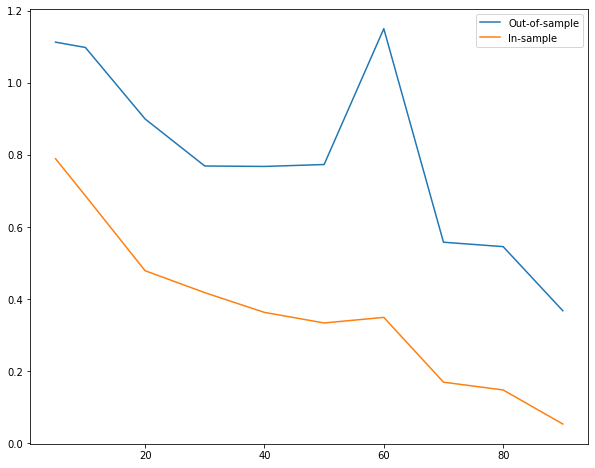

In [8]:
# Q2
M = np.arange(1,10)*10
M = M.tolist()

track_performance_out = [performance(stock_loc5, w5, df=df2)]
track_performance_in = [performance(stock_loc5, w5, df=df1)]

for i in M:
    x, objval5 = create_optimize(m=i)
    w, stock_loc = get_weight(x=x, df=df1, m=i)
    track_performance_out.append(performance(stock_loc, w, df=df2))
    track_performance_in.append(performance(stock_loc, w, df=df1))

M.insert(0,5)    
plot_performance(track_performance_out,  track_performance_in, M)

In [9]:
#Q3
w5, stock_loc5 = optimize_weight(m=5, df=df1)

C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  


In [10]:
# Get performance of the index fund created
def performance2(stock_loc, w, df=df2):
    stocks = df.iloc[:,stock_loc[1:]].to_numpy()
    index = df.iloc[:,0].to_numpy()
    
    # Obtain the weight of the chosen stocks only 
    # Subtract 1 to adjust to the right position
    w = np.array(w)
    weight = w[(np.array(stock_loc)-1).tolist()[1:]]
    return abs(index - stocks.dot(weight)).sum()


M = np.arange(1,10)*10
M = M.tolist()
M.insert(0,5)    
#track_performance_out_2 = [performance(stock_loc5, w5, df=df2)]
#track_performance_in_2 = [performance(stock_loc5, w5, df=df1)]

track_performance_out_2 = []
track_performance_in_2 = []

for i in M:
    w, stock_loc = optimize_weight(m=i, df=df1)
    track_performance_out_2.append(performance2(stock_loc, w, df=df2))
    track_performance_in_2.append(performance2(stock_loc, w, df=df1))

#M.insert(0,5)     

C:\Users\derek\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Deprecated, use Model.addMConstr() instead


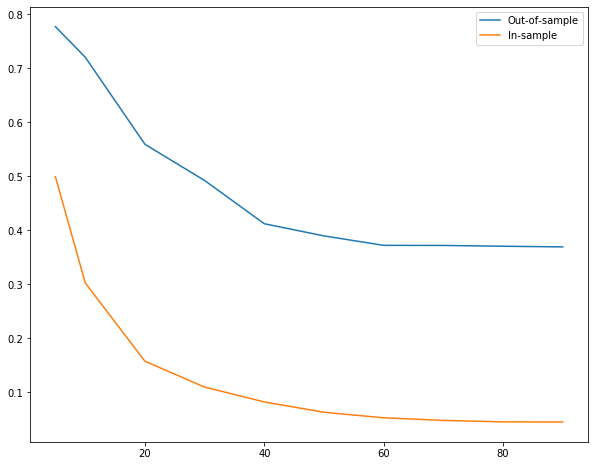

In [11]:
# Plot performance
plot_performance(track_performance_out_2,  track_performance_in_2, M)